# Dataset

## Importación de librerías

### Sistema

In [ ]:
import os
from dotenv import load_dotenv

### Llamadas

In [ ]:
import requests
import urllib.parse

In [ ]:
!pip install nest_asyncio

In [ ]:
import aiohttp
import asyncio
import nest_asyncio
nest_asyncio.apply()

### Datos

In [2]:
import csv
import pandas as pd
import numpy as np
import json
# import ijson
from itertools import combinations
from collections import Counter

### Visualización

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## Recolección de datos

In [ ]:
!curl ifconfig.me

34.16.151.253

In [ ]:
load_dotenv()
api_token = os.getenv("API_TOKEN")

In [ ]:
from google.colab import userdata
api_token = userdata.get('API_TOKEN')

In [ ]:
def api_call(url):
    payload = {}
    headers = {
    'Authorization': f'Bearer {api_token}'
    }

    response = requests.request("GET", url, headers=headers, data=payload)
    data = response.json()

    return data

In [ ]:
def encoded_tag(tag):
    return urllib.parse.quote(tag)

### Clans

In [ ]:
n_players = 50000
players_per_clan = 30
n_clans = int(n_players / 30)

In [ ]:
data = api_call(f"https://api.clashroyale.com/v1/clans?minMembers={players_per_clan}&limit={n_clans}")

In [ ]:
clan_tags = [clan["tag"] for clan in data["items"]]
print(len(clan_tags))

1666


**Clan members**

In [ ]:
player_tags = []

with open("player_tags.csv", "w", newline='') as file:
    writer = csv.writer(file)
    for clan in clan_tags:
        encoded = encoded_tag(clan)
        data = api_call(f"https://api.clashroyale.com/v1/clans/{encoded}/members")
        new_tags = [member["tag"] for member in data["items"]]
        player_tags += new_tags
        for player in new_tags:
            writer.writerow([player])

In [ ]:
print(len(player_tags))

73113


### Cards

In [ ]:
data = api_call("https://api.clashroyale.com/v1/cards")

In [ ]:
all_cards = [card["id"] for card in data["items"]]

In [ ]:
card_rows = []

for card in data["items"]:
    card_info = {
        "id": card["id"],
        "name": card["name"],
        "rarity": card.get("rarity", None),
        "elixirCost": card.get("elixirCost", None),
        "maxLevel": card.get("maxLevel", None),
        "maxEvolutionLevel": card.get("maxEvolutionLevel", None),
        "icon": card.get("iconUrls", {}).get("medium", None),
        "evolution_icon": card.get("iconUrls", {}).get("evolutionMedium", None)
    }
    card_rows.append(card_info)

cards_df = pd.DataFrame(card_rows)
cards_df.to_csv("game_cards.csv", index=False)

In [ ]:
cards_df

,id,name,rarity,elixirCost,maxLevel,maxEvolutionLevel,icon,evolution_icon
0,26000000,Knight,common,3.0,14,1.0,https://api-assets.clashroyale.com/cards/300/j...,https://api-assets.clashroyale.com/cardevoluti...
1,26000001,Archers,common,3.0,14,1.0,https://api-assets.clashroyale.com/cards/300/W...,https://api-assets.clashroyale.com/cardevoluti...
2,26000002,Goblins,common,2.0,14,NaN,https://api-assets.clashroyale.com/cards/300/X...,None
3,26000003,Giant,rare,5.0,12,NaN,https://api-assets.clashroyale.com/cards/300/A...,None
4,26000004,P.E.K.K.A,epic,7.0,9,1.0,https://api-assets.clashroyale.com/cards/300/M...,https://api-assets.clashroyale.com/cardevoluti...
...,...,...,...,...,...,...,...,...
116,28000018,Royal Delivery,common,3.0,14,NaN,https://api-assets.clashroyale.com/cards/300/L...,None
117,28000023,Void,epic,3.0,9,NaN,https://api-assets.clashroyale.com/cards/300/B...,None
118,28000024,Goblin Curse,epic,2.0,9,NaN,https://api-assets.clashroyale.com/cards/300/O...,None
119,28000025,Spirit Empress,legendary,6.0,6,NaN,https://api-assets.clashroyale.com/cards/300/M...,None


### Players

In [ ]:
df_tags = pd.read_csv("player_tags.csv", header=None)
player_tags = df_tags[0].tolist()
print(len(player_tags))

73113


In [ ]:
player_tags = player_tags[:7*10000]
print(len(player_tags))

70000

Dada la alta cantidad de llamadas, se decide realizar grupos de llamadas en paralelo

* tag
* name
* expLevel
* trophies
* bestTrophies
* wins
* losses
* battleCount
* threeCrownWins
* arena
* clan
* favCard
* starPoints
* expPoints
* totalExpPoints

In [ ]:
def extract_player_stats(data):
    return {
        "tag": data.get("tag"),
        "name": data.get("name"),
        "expLevel": data.get("expLevel"),
        "trophies": data.get("trophies"),
        "bestTrophies": data.get("bestTrophies"),
        "wins": data.get("wins"),
        "losses": data.get("losses"),
        "battleCount": data.get("battleCount"),
        "threeCrownWins": data.get("threeCrownWins"),
        "arena": data.get("arena", {}).get("name"),
        "clan": data.get("clan", {}).get("name"),
        "favCard": data.get("currentFavouriteCard", {}).get("name"),
        "starPoints": data.get("starPoints"),
        "expPoints": data.get("expPoints"),
        "totalExpPoints": data.get("totalExpPoints")
    }

In [ ]:
async def api_call_async(session, url, retries=3):
    headers = {
        'Authorization': f'Bearer {api_token}'
    }

    for attempt in range(retries):
        try:
            async with session.get(url, headers=headers) as response:
                if response.status == 200:
                    return await response.json()
                elif response.status == 429:
                    print("Rate limited. Esperando 5 segundos...")
                    await asyncio.sleep(5)
                else:
                    print(f"Error {response.status} en {url}")
                    return None
        except aiohttp.ClientError as e:
            print(f"Conexión fallida: {e}")
            await asyncio.sleep(1)

    return None

In [ ]:
def upgrade_relevance(relevant_cards, valid_cards, player_interactions):
    for card in relevant_cards:
        card_id = card["id"]
        if card_id in valid_cards:
            player_interactions[card_id] += 1

In [ ]:
async def fetch_user_data(session, tag, all_cards):
    encoded = encoded_tag(tag)
    url = f"https://api.clashroyale.com/v1/players/{encoded}"
    data = await api_call_async(session, url)

    if (not data) or ("cards" not in data):
        print(f"Falló obtener datos de {tag}")
        return None

    user_cards = {card_id: 0 for card_id in all_cards}
    user_cards["tag"] = tag

    upgrade_relevance(data["cards"], all_cards, user_cards)
    upgrade_relevance(data["currentDeck"], all_cards, user_cards)

    player_stats = extract_player_stats(data)

    return (user_cards, player_stats)

In [ ]:
def log_progress(current, total, step):
    if (current % step == 0) or (current == total):
        print(f"{current}/{total} usuarios scrappeados")

In [ ]:
async def main(player_tags, all_cards, batch_size):
    card_columns = ["tag"] + all_cards
    df_cards = pd.DataFrame(columns=card_columns)
    df_stats = pd.DataFrame(columns=[
        "tag", "name", "expLevel", "trophies", "bestTrophies",
        "wins", "losses", "battleCount", "threeCrownWins",
        "arena", "clan", "favCard", "starPoints", "expPoints", "totalExpPoints"
    ])

    total = len(player_tags)

    async with aiohttp.ClientSession() as session:
        for i in range(0, total, batch_size):
            batch = player_tags[i:i+batch_size]
            tasks = [fetch_user_data(session, tag, all_cards) for tag in batch]
            results = await asyncio.gather(*tasks, return_exceptions=True)

            for res in results:
                if isinstance(res, tuple):
                    user_row, player_stats = res
                    df_cards.loc[len(df_cards)] = user_row
                    df_stats.loc[len(df_stats)] = player_stats

            log_progress(i + len(batch), total, 1000)
            await asyncio.sleep(1.5)

    df_cards.to_csv("player_cards.csv", index=False)
    df_stats.to_csv("player_stats.csv", index=False)

In [ ]:
for i in range(1, 100):
    if (len(player_tags) % i) == 0:
        print(i)

1
2
4
5
7
8
10
14
16
20
25
28
35
40
50
56
70
80


La siguiente celda se demoró `>70` min. en ejecutarse desde Google Colab,

In [ ]:
await main(player_tags, all_cards, 80)

2000/70000 usuarios scrappeados
4000/70000 usuarios scrappeados
6000/70000 usuarios scrappeados
8000/70000 usuarios scrappeados
10000/70000 usuarios scrappeados
12000/70000 usuarios scrappeados
14000/70000 usuarios scrappeados
16000/70000 usuarios scrappeados
18000/70000 usuarios scrappeados
20000/70000 usuarios scrappeados
22000/70000 usuarios scrappeados
24000/70000 usuarios scrappeados
26000/70000 usuarios scrappeados
28000/70000 usuarios scrappeados
30000/70000 usuarios scrappeados
32000/70000 usuarios scrappeados
34000/70000 usuarios scrappeados
36000/70000 usuarios scrappeados
38000/70000 usuarios scrappeados
40000/70000 usuarios scrappeados
42000/70000 usuarios scrappeados
44000/70000 usuarios scrappeados
46000/70000 usuarios scrappeados
48000/70000 usuarios scrappeados
50000/70000 usuarios scrappeados
52000/70000 usuarios scrappeados
54000/70000 usuarios scrappeados
56000/70000 usuarios scrappeados
58000/70000 usuarios scrappeados
60000/70000 usuarios scrappeados
62000/70000 us

## Entendimiento de los datos

In [12]:
player_cards = pd.read_csv('player_cards.csv')
game_cards = pd.read_csv('game_cards.csv')
player_stats = pd.read_csv('player_stats.csv')

### Game Cards

In [16]:
game_cards.describe()

,id,elixirCost,maxLevel,maxEvolutionLevel
count,1.210000e+02,120.000000,121.000000,38.0
mean,2.648764e+07,3.975000,10.090909,1.0
std,7.970185e+05,1.541921,3.214550,0.0
min,2.600000e+07,1.000000,4.000000,1.0
25%,2.600003e+07,3.000000,9.000000,1.0
50%,2.600006e+07,4.000000,9.000000,1.0
75%,2.700000e+07,5.000000,12.000000,1.0
max,2.800003e+07,9.000000,14.000000,1.0


### Player Cards

In [ ]:
player_cards

,tag,26000000,26000001,26000002,26000003,26000004,26000005,26000006,26000007,26000008,...,28000013,28000014,28000015,28000016,28000017,28000018,28000023,28000024,28000025,28000026
0,#VL0QCY9R8,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,#L0092LLGP,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,#LU2QQJU0Y,1,1,1,1,1,2,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,#999QV8RJU,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,#2G22QVP89,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,#UJRGJGYJG,1,2,1,1,1,1,1,1,1,...,0,1,1,1,1,1,0,1,0,1
69996,#20YQV9Y9GQ,2,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1
69997,#CJVL82CQC,1,1,1,1,1,1,1,2,1,...,0,1,1,1,1,1,0,0,0,1
69998,#CJQYRRY0G,1,1,1,1,1,1,1,2,1,...,0,1,1,1,1,1,0,1,0,1


In [ ]:
player_cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 122 entries, tag to 28000026
dtypes: int64(121), object(1)
memory usage: 65.2+ MB


In [ ]:
player_cards.describe()

,26000000,26000001,26000002,26000003,26000004,26000005,26000006,26000007,26000008,26000009,...,28000013,28000014,28000015,28000016,28000017,28000018,28000023,28000024,28000025,28000026
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,1.226643,1.134129,1.022300,1.043829,1.047429,1.096329,1.008529,1.175229,1.028914,0.909300,...,0.805429,0.892714,0.974686,0.845586,0.984729,0.858771,0.782414,0.817657,0.689543,0.931200
std,0.418663,0.340793,0.156945,0.204715,0.364509,0.295043,0.364614,0.469177,0.239808,0.345858,...,0.424973,0.406350,0.399094,0.375881,0.352517,0.436218,0.417050,0.419775,0.474212,0.438778
min,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [ ]:
card_cols = [col for col in player_cards.columns if col != "tag"]

unique_decks = set()

for _, row in player_cards.iterrows():
    deck = tuple(sorted([card for card in card_cols if row[card] == 2]))
    if len(deck) == 8:
        unique_decks.add(deck)

print(f"Mazos únicos: {len(unique_decks)}")

Mazos únicos: 58122


In [ ]:
def get_cards_names(game_cards, cards_ids):
    id_2_name = dict(zip(game_cards["id"], game_cards["name"]))
    cards_names = [id_2_name[int(card_id)] for card_id in cards_ids]
    return cards_names

def get_all_cards_of_player(player_tag, df):
    if player_tag not in df["tag"].values:
        print(f"Usuario {player_tag} no encontrado.")
        return None

    user_row = df[df["tag"] == player_tag].iloc[0]
    card_cols = [col for col in df.columns if col != "tag"]
    cards_ids = [card_id for card_id in card_cols if user_row[card_id] >= 1]

    return get_cards_names(game_cards, cards_ids)

def get_current_deck_of_player(player_tag, df):
    if player_tag not in df["tag"].values:
        print(f"Usuario {player_tag} no encontrado.")
        return None

    user_row = df[df["tag"] == player_tag].iloc[0]
    card_cols = [col for col in df.columns if col != "tag"]
    deck = [card_id for card_id in card_cols if user_row[card_id] == 2]

    return get_cards_names(game_cards, deck)

### Player Stats

In [13]:
player_stats

,tag,name,expLevel,trophies,bestTrophies,wins,losses,battleCount,threeCrownWins,arena,clan,favCard,starPoints,expPoints,totalExpPoints
0,#VL0QCY9R8,grokiki,61,10000,10000,3528,1373,4901,1719,Legendary Arena,! ares ¡,Bandit,755009.0,28938,2082708
1,#L0092LLGP,groskyja,70,10000,10000,10171,6185,16356,7829,Legendary Arena,! ares ¡,Mega Knight,5000000.0,0,7163219
2,#LU2QQJU0Y,max ツ,62,10000,10000,5751,4678,10429,2594,Legendary Arena,! ares ¡,Electro Dragon,476756.0,205935,2559705
3,#999QV8RJU,NLE_Freezer56,56,10000,10000,2959,2970,5929,1593,Legendary Arena,! ares ¡,Goblin Giant,264675.0,94330,1023100
4,#2G22QVP89,Samshiro,65,10000,10000,13762,14743,28505,6779,Legendary Arena,! ares ¡,Royal Recruits,936182.0,22091,3425861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,#UJRGJGYJG,mighty mill,30,5151,5152,573,455,1028,332,Miner's Mine,OUTSKIRT,Mega Knight,5279.0,2984,41754
69996,#20YQV9Y9GQ,snakejem12,34,5140,5345,507,364,871,320,Miner's Mine,OUTSKIRT,The Log,34567.0,3497,77267
69997,#CJVL82CQC,Pexgan,32,4993,4993,366,211,577,266,Serenity Peak,OUTSKIRT,Goblin Gang,13341.0,1030,54800
69998,#CJQYRRY0G,Victor,31,4980,4980,409,286,695,234,Serenity Peak,OUTSKIRT,Witch,575.0,1355,47125


In [15]:
player_stats.describe()

,expLevel,trophies,bestTrophies,wins,losses,battleCount,threeCrownWins,starPoints,expPoints,totalExpPoints
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,6.998500e+04,70000.000000,7.000000e+04
mean,39.960457,7192.451329,7243.626771,2123.435957,1920.739714,4044.175671,993.282857,1.980261e+05,26959.569100,4.736194e+05
std,13.112007,2652.030336,2651.294872,3726.604741,3674.660487,7364.617286,1637.551285,6.082374e+05,54949.189032,8.989881e+05
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00
25%,32.000000,5627.000000,5710.000000,470.000000,310.000000,783.000000,225.000000,7.301000e+03,2209.000000,5.667575e+04
50%,39.000000,7680.000000,7775.000000,965.000000,794.000000,1767.000000,483.000000,2.374300e+04,7135.000000,1.551675e+05
75%,50.000000,9693.000000,9810.000000,2044.000000,1887.000000,3934.000000,1028.000000,8.000400e+04,18724.250000,4.214602e+05
max,70.000000,10000.000000,10000.000000,84981.000000,85828.000000,170809.000000,35357.000000,5.000000e+06,499308.000000,8.043517e+06


## Visualización de los datos

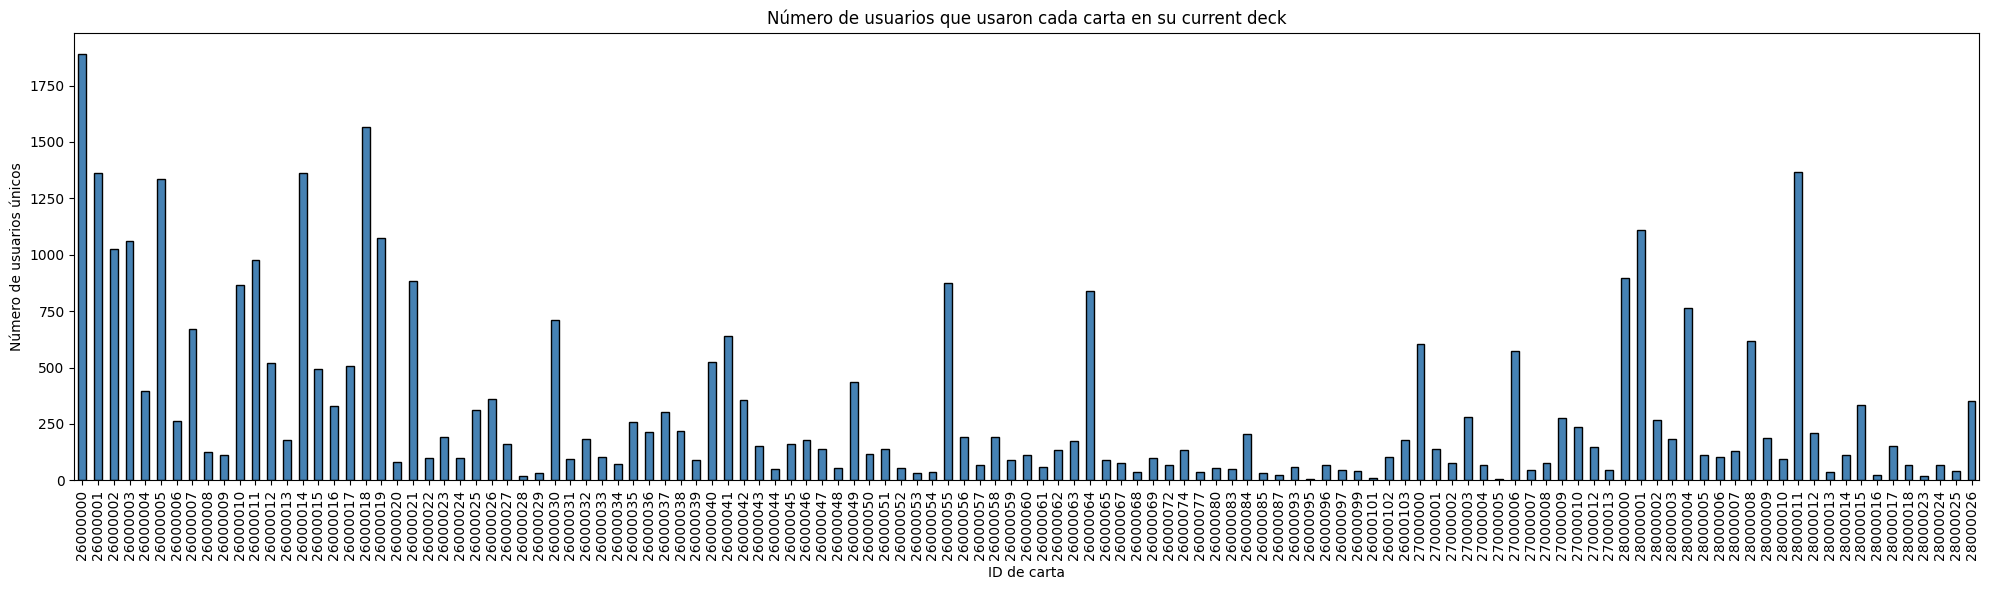

In [ ]:
used_cards_df = df[df["interaction"] == 1]

users_per_card = used_cards_df.groupby("card_id")["user_id"].nunique()

plt.figure(figsize=(20,6))
users_per_card.plot(kind="bar", color="steelblue", edgecolor="black")

plt.title("Número de usuarios que usaron cada carta en su current deck")
plt.xlabel("ID de carta")
plt.ylabel("Número de usuarios únicos")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Co-ocurrencia**

In [ ]:
current_deck_df = df[df["interaction"] == 1]

pair_counter = Counter()

for user_id, group in current_deck_df.groupby("user_id"):
    deck_cards = group["card_id"].tolist()
    pairs = combinations(sorted(deck_cards), 2)
    pair_counter.update(pairs)

card_index = {card: idx for idx, card in enumerate(cards)}
n_cards = len(cards)

In [ ]:
co_matrix = np.zeros((n_cards, n_cards), dtype=int)

for (card1, card2), count in pair_counter.items():
    i, j = card_index[card1], card_index[card2]
    co_matrix[i, j] = count
    co_matrix[j, i] = count

co_df = pd.DataFrame(co_matrix, index=cards, columns=cards)

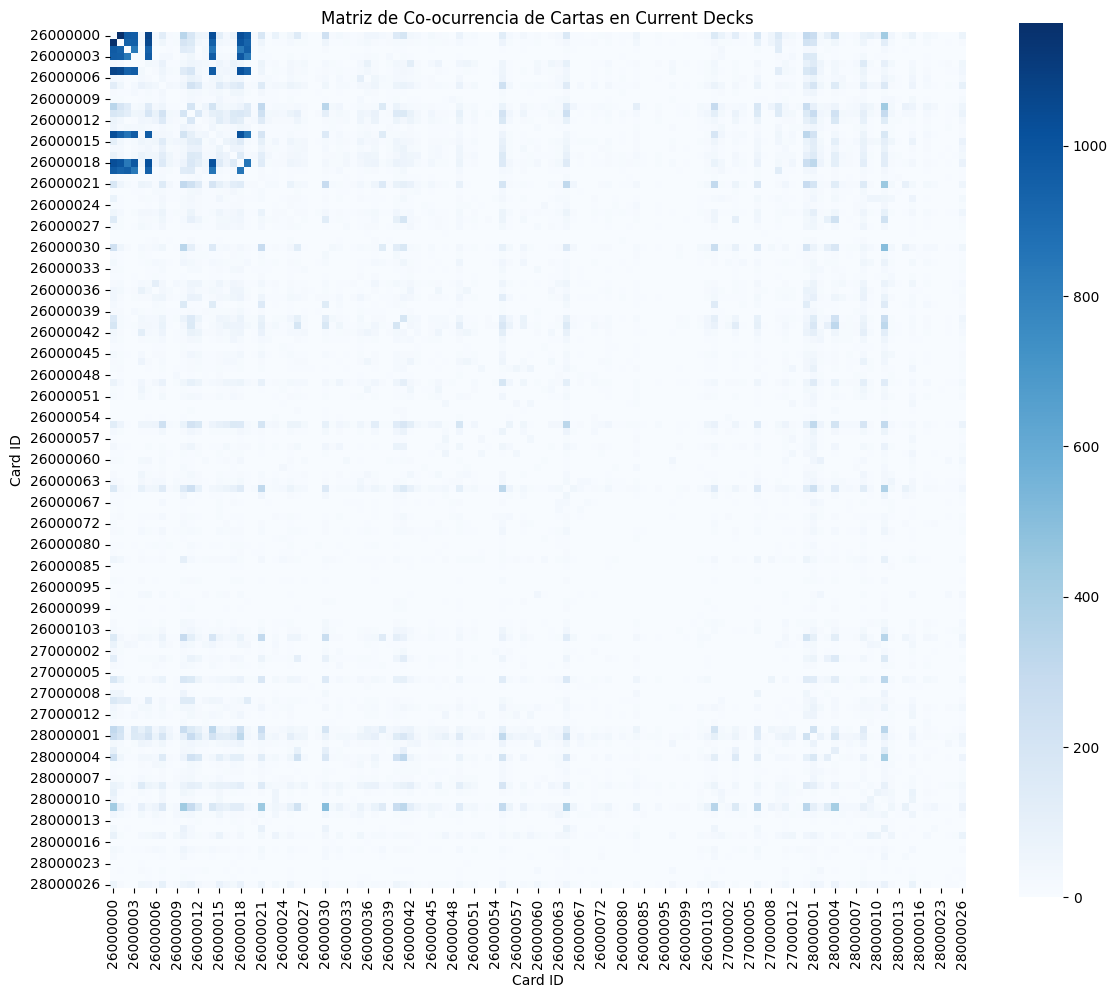

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(co_df, cmap="Blues", square=True)
plt.title("Matriz de Co-ocurrencia de Cartas en Current Decks")
plt.xlabel("Card ID")
plt.ylabel("Card ID")
plt.tight_layout()
plt.show()